In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Neural Net Model

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class GPN(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_class):
        super(GPN, self).__init__()
        self.size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        v  = torch.FloatTensor(n_hidden).cuda()
        h0 = torch.FloatTensor(n_hidden).cuda()
        c0 = torch.FloatTensor(n_hidden).cuda()

        gamma = torch.ones(1).cuda()
        self.v  = nn.Parameter(v)
        self.h0 = nn.Parameter(h0)
        self.c0 = nn.Parameter(c0)
        self.r1  = nn.Parameter(r1)
        self.r2  = nn.Parameter(r2)
        self.r3  = nn.Parameter(r3)
        self.gamma = nn.Parameter(gamma)
        self.v.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.h0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.c0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        # embedding
        self.embedding_x = nn.Linear(n_feature, n_hidden)
        self.embedding_all = nn.Linear(n_feature, n_hidden)
        
        self.encoder_1 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
        self.encoder_2 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder        
        self.encoder_3 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
        
        self.enc_1 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
        self.enc_2 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder        
        self.enc_3 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
                
        # parameters for input gate
        self.Wxi = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whi = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wci = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for forget gate
        self.Wxf = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whf = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wcf = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for cell gate
        self.Wxc = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whc = nn.Linear(n_hidden, n_hidden)    # W(ht)
        
        # parameters for forget gate
        self.Wxo = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Who = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wco = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for pointer attention
        self.Wref = nn.Linear(n_hidden, n_hidden)
        self.Wq = nn.Linear(n_hidden, n_hidden)
        
        
    def forward(self, x, input, mask, h=None, c=None):
        ''' args
        x: current city (B, 2)
        input: all cities (B*size, 2)
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        context: encoded context, encoder(input) --> (B*size, dim)
        '''
        self.batch_size = x.size(0)
        self.size = int(input.size(0) / self.batch_size)
        
        if h is None:
            h = self.h0.unsqueeze(0).expand(self.batch_size, self.dim)
        if c is None:
            c = self.c0.unsqueeze(0).expand(self.batch_size, self.dim)

        # pointer embedding
        x = self.embedding_x(x)
        context = self.embedding_all(input)
        
        context = self.enc_1(context) + F.relu(self.encoder_1(context))
        # context = self.enc_2(context) + F.relu(self.encoder_2(context))
        # context = self.enc_3(context) + F.relu(self.encoder_3(context))
                
        # hidden variable does not have graph structure
        # input gate
        i = torch.sigmoid(self.Wxi(x) + self.Whi(h) + self.wci(c))
        # forget gate
        f = torch.sigmoid(self.Wxf(x) + self.Whf(h) + self.wcf(c))
        # cell gate
        c = f*c + i*torch.tanh(self.Wxc(x) + self.Whc(h))
        # output gate
        o = torch.sigmoid(self.Wxo(x) + self.Who(h) + self.wco(c))
        h = o*torch.tanh(c)
        

        # query and reference
        q = h
        ref = context
        q = self.Wq(q)     # (B, dim)
        ref = self.Wref(ref)
        ref = ref.view(self.batch_size, self.size, self.dim)  # (B, size, dim)
        
        q_ex = q.unsqueeze(1).repeat(1, self.size, 1) # (B, size, dim)
        # v_view: (B, dim, 1)
        v_view = self.v.unsqueeze(0).expand(self.batch_size, self.dim).unsqueeze(2)
        
        # (B, size, dim) * (B, dim, 1)
        u = torch.bmm(torch.tanh(q_ex + ref), v_view).squeeze(2)
        hidden_u = u.clone()
        u = 10*torch.tanh(u) + mask
        return F.softmax(u, dim=1), h, c, hidden_u

## with vector embedding

In [0]:
# gnn for predice large scale TSP
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class GPN(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_class):
        super(GPN, self).__init__()
        self.size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        v  = torch.FloatTensor(n_hidden).cuda()
        h0 = torch.FloatTensor(n_hidden).cuda()
        c0 = torch.FloatTensor(n_hidden).cuda()
        r1 = torch.ones(1).cuda()
        r2 = torch.ones(1).cuda()
        r3 = torch.ones(1).cuda()
        gamma = torch.ones(1).cuda()
        self.v  = nn.Parameter(v)
        self.h0 = nn.Parameter(h0)
        self.c0 = nn.Parameter(c0)
        self.r1  = nn.Parameter(r1)
        self.r2  = nn.Parameter(r2)
        self.r3  = nn.Parameter(r3)
        self.gamma = nn.Parameter(gamma)
        self.v.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.h0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.c0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        # embedding
        self.embedding_x = nn.Linear(n_feature, n_hidden)
        self.embedding_all = nn.Linear(n_feature, n_hidden)
        
        self.encoder_1 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
        self.encoder_2 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder        
        self.encoder_3 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
        
        self.enc_1 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
        self.enc_2 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder        
        self.enc_3 = nn.Linear(n_hidden, n_hidden)    # use GCN as encoder
                
        # parameters for input gate
        self.Wxi = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whi = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wci = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for forget gate
        self.Wxf = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whf = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wcf = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for cell gate
        self.Wxc = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whc = nn.Linear(n_hidden, n_hidden)    # W(ht)
        
        # parameters for forget gate
        self.Wxo = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Who = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wco = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for pointer attention
        self.Wref = nn.Linear(n_hidden, n_hidden)
        self.Wq = nn.Linear(n_hidden, n_hidden)
        
        
    def forward(self, x, input, mask, h=None, c=None):
        '''
        args
        x: current city (B, 2)
        input: all cities (B*size, 2)
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        context: encoded context, encoder(input) --> (B*size, dim)
        '''
        self.batch_size = x.size(0)
        self.size = int(input.size(0) / self.batch_size)
        
        if h is None:
            h = self.h0.unsqueeze(0).expand(self.batch_size, self.dim)
        if c is None:
            c = self.c0.unsqueeze(0).expand(self.batch_size, self.dim)
        
        # embedding
        x_expand = x.unsqueeze(1).repeat(1, self.size, 1) # (B, size, 2)
        x_expand = x_expand.view(-1,2)
        # vector embedding
        input = input - x_expand    
        
        x = self.embedding_x(x)
        context = self.embedding_all(input)
        context = self.enc_1(context) + F.relu(self.encoder_1(context))

        # hidden variable does not have graph structure
        # input gate
        i = torch.sigmoid(self.Wxi(x) + self.Whi(h) + self.wci(c))
        # forget gate
        f = torch.sigmoid(self.Wxf(x) + self.Whf(h) + self.wcf(c))
        # cell gate
        c = f*c + i*torch.tanh(self.Wxc(x) + self.Whc(h))
        # output gate
        o = torch.sigmoid(self.Wxo(x) + self.Who(h) + self.wco(c))
        h = o*torch.tanh(c)       

        # query and reference
        q = h
        ref = context
        q = self.Wq(q)     # (B, dim)
        ref = self.Wref(ref)
        ref = ref.view(self.batch_size, self.size, self.dim)  # (B, size, dim)
        # print(ref.size())
        
        q_ex = q.unsqueeze(1).repeat(1, self.size, 1) # (B, size, dim)

        # v_view: (B, dim, 1)
        v_view = self.v.unsqueeze(0).expand(self.batch_size, self.dim).unsqueeze(2)
        
        # (B, size, dim) * (B, dim, 1)
        u = torch.bmm(torch.tanh(q_ex + ref), v_view).squeeze(2)

        hidden_u = u.clone()
        u = 10*torch.tanh(u) + mask
        return F.softmax(u, dim=1), h, c, hidden_u


# Training

In [0]:
import numpy as np

import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from scipy.spatial.distance import squareform, pdist
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [0]:
size = 50
learn_rate = 1e-3
beta = 0.8
B = 128

In [0]:
model = GPN(n_feature=2,
            n_hidden=128,
            n_class=1)

In [0]:
model.cuda()

learn_rate = 1e-3
lr_decay_step = 5000
lr_decay_rate = 0.96


optimizer = optim.Adam(model.parameters(), lr=learn_rate)

opt_scheduler = lr_scheduler.MultiStepLR(optimizer, range(lr_decay_step, lr_decay_step*1000,
                                         lr_decay_step), gamma=lr_decay_rate)

# TSP

In [0]:
B = 128    # batch_size
C = 0     # baseline
R = 0     # reward

R_mean = []
R_std = []

for i in range(20000):
    optimizer.zero_grad()

    X = np.random.rand(B*size, 2)        

    X = torch.Tensor(X).cuda()
    
    mask = torch.zeros(B,size).cuda()

    R = 0
    logprobs = 0
    reward = 0
    
    Y = X.view(B,size,2)           # to the same batch size
    x = Y[:,0,:]
    h = None
    c = None

    for k in range(size):
        
        output, h, c, _ = model(x=x, input=X, h=h, c=c, mask=mask)
        
        sampler = torch.distributions.Categorical(output)
        idx = sampler.sample()         # now the idx has B elements

        # print(output)
        Y1 = Y[[i for i in range(B)], idx.data].clone()
        if k == 0:
            Y_ini = Y1.clone()
        if k > 0:
            reward = torch.norm(Y1-Y0, dim=1)
            
        Y0 = Y1.clone()
        x = Y[[i for i in range(B)], idx.data].clone()
        
        R += reward
            
        TINY = 1e-15
        logprobs += torch.log(output[[i for i in range(B)], idx.data]+TINY) 
        
        mask[[i for i in range(B)], idx.data] += -np.inf 
        
    R += torch.norm(Y1-Y_ini, dim=1)
    
    if i == 0:
        C = R.mean()
    else:
        C = (C * beta) + ((1. - beta) * R.mean())
    
    loss = ((R-C)*logprobs).mean()

    loss.backward()
    
    max_grad_norm = 1.0
    torch.nn.utils.clip_grad_norm_(model.parameters(),
                                       max_grad_norm, norm_type=2)
    optimizer.step()
    opt_scheduler.step()
    
    if i % 50 == 0:
        print("epoch:{}, loss:{}, reward:{}"
            .format(i,loss.item(),R.mean().item()))
        R_mean.append(R.mean().item())
        R_std.append(R.std().item())

epoch:0, loss:-0.3038368225097656, reward:25.814903259277344
epoch:50, loss:55.735679626464844, reward:10.755695343017578
epoch:100, loss:2.363403081893921, reward:8.175188064575195
epoch:150, loss:-4.556140899658203, reward:8.10903549194336
epoch:200, loss:-0.4085063934326172, reward:7.847185134887695
epoch:250, loss:-1.1558071374893188, reward:7.906917572021484
epoch:300, loss:1.9310168027877808, reward:7.8872880935668945
epoch:350, loss:-4.577587604522705, reward:7.959246635437012
epoch:400, loss:-3.6379246711730957, reward:7.831960678100586
epoch:450, loss:3.1916260719299316, reward:7.735561847686768
epoch:500, loss:-5.477538108825684, reward:8.257938385009766
epoch:550, loss:-1.5729929208755493, reward:7.655742645263672
epoch:600, loss:3.2240772247314453, reward:7.643123149871826
epoch:650, loss:-3.225764036178589, reward:7.841393947601318
epoch:700, loss:-2.4506359100341797, reward:7.651365280151367
epoch:750, loss:1.493720293045044, reward:7.6856842041015625
epoch:800, loss:-3.9

(400,)


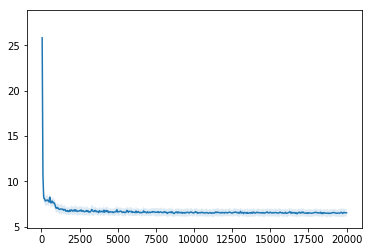

In [0]:
R_mean = np.array(R_mean)
R_std = np.array(R_std)
print(R_mean.shape)
k = np.arange(50, 50*(R_mean.shape[0]+1), 50)
plt.plot(k, R_mean)
plt.fill_between(k, R_mean-R_std, R_mean+R_std, alpha=0.15)
plt.show()

# TSP20

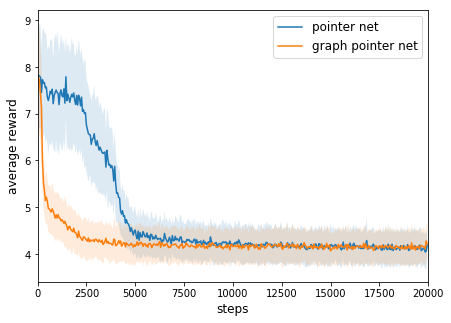

In [0]:
plt.figure(figsize = (7,5))

k = np.arange(50, 50*(R_mean_PN.shape[0]), 50)
plt.plot(k, R_mean_PN[:-1], label='pointer net')
plt.fill_between(k, R_mean_PN[:-1] - R_std_PN[:-1], R_mean_PN[:-1]+R_std_PN[:-1], alpha=0.15)


k = np.arange(50, 50*(R_mean_GPN.shape[0]), 50)
plt.plot(k, R_mean_GPN[1:], label='graph pointer net')
plt.fill_between(k, R_mean_GPN[1:]-R_std_GPN[1:], R_mean_GPN[1:]+R_std_GPN[1:], alpha=0.15)

plt.xlim((0, 20000))
plt.xlabel('steps', fontsize=12)
plt.ylabel('average reward', fontsize=12)
plt.legend(loc='upper right', fontsize=12)

plt.show()

# TSP50

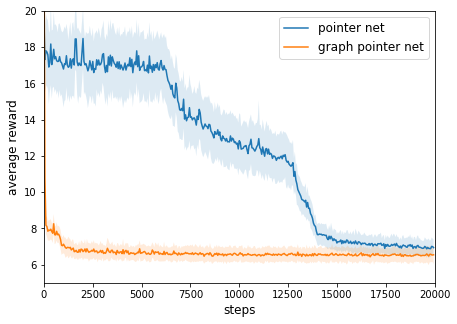

In [0]:
plt.figure(figsize = (7,5))

k = np.arange(0, 50*(R_mean_PN.shape[0]), 50)
plt.plot(k, R_mean_PN, label='pointer net')
plt.fill_between(k, R_mean_PN - R_std_PN, R_mean_PN+R_std_PN, alpha=0.15)


k = np.arange(0, 50*(R_mean_GPN.shape[0]), 50)
plt.plot(k, R_mean_GPN[:], label='graph pointer net')
plt.fill_between(k, R_mean_GPN-R_std_GPN, R_mean_GPN+R_std_GPN, alpha=0.15)

plt.xlim((0, 20000))
plt.ylim((5, 20))
plt.xlabel('steps', fontsize=12)
plt.ylabel('average reward', fontsize=12)
plt.legend(loc='upper right', fontsize=12)

plt.show()